# Data Science Challenge - Semantix Brasil
## Author: Andre Guimaraes Duarte
## Date: March 2018
### Source data: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The data used for this challenge relates to direct marketing campaigns of an undisclosed Portuguese banking institution from 2008 to 2010. The marketing campaigns were based on phone calls, either home (telephone) or cellular. The dependent variable in this dataset is called "y" and denotes whether the client (one client per line) subscribed to a bank term deposit. 

The dataset contains information about each client, such as age, occupation, marital status, degree of education, whether they have defaulted before, their average monthly account balance, whether they have a housing or personal loan, they day and month of last contact, the duration of the last contact, how many contacts were made, as well as previous campaign results.

Using this dataset, it is possible to use data science techniques to do several things. For this challenge, I will limit myself to answering the questions asked about the dataset. Time permitting, I will delve deeper into machine learning models, such as classification to predict whether a client will subscribe to a bank term deposit using logistic regression and random forests.

# Exploratory Data Analysis
The first step when dealing with a new dataset is to explore it, perform early visualizations, look for missing data and potentially imputing said missing data, etc.

## First look at the data
Here, we will start getting our hands dirty by taking a first overview of the data.

In [1]:
# import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")

In [2]:
# Import packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
!pwd

/home/andre/Documents/BankMarketing


In [4]:
file_path = "/home/andre/Documents/BankMarketing/bank-full.csv"
df = pd.read_csv(file_path, sep=";", header=0)

In [5]:
df.shape

(45211, 17)

The dataset has 45,211 lines/observations (clients) and 17 columns (variables). Let's have a look at their types. We are dealing with both numeric and categorical variables, which we might have to modify in order to build our model.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

We can see that there are no missing data points in the dataset. We will not have to perform any imputing.

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


It might be necessary to standardize the numeric fields before constructing our classification model, so that the variables can be assigned weights independent of their spread.

In [10]:
df.describe(include=["object"])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [11]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Out of all the clients, 39.922 result in y="no", while only 5,289 result in y="yes". This means that the accuracy of a model that only predicts "no" will be 88.3% for this dataset. Whatever model we construct needs to perform at least as well as this baseline.

Since we have the day and month, let's construct new columns with the full date as well as the day of week. The date field can allow us to plot time-series for example, although I do not do it in this notebook due to time constraints.

In [12]:
df.loc[:27728,'year'] = '2008'
df.loc[27729:42591,'year'] = '2009'
df.loc[42592:,'year'] = '2010'
df["date"] = pd.to_datetime(df["day"].map(str) + df["month"] + "2008", format="%d%b%Y")
df['weekday'] = df['date'].dt.weekday_name
df.drop(["day","year"], axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,date,weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,unknown,no,2008-05-05,Monday
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,unknown,no,2008-05-05,Monday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,unknown,no,2008-05-05,Monday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,unknown,no,2008-05-05,Monday
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,unknown,no,2008-05-05,Monday


Let's also create a numeric casting of our response variable `y` to be binary ("yes"->1, "no"->0) . We'll save it in a new column for now.

In [13]:
df["num_y"] = df.y.map({'yes':1, 'no':0})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,date,weekday,num_y
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,unknown,no,2008-05-05,Monday,0
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,unknown,no,2008-05-05,Monday,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,unknown,no,2008-05-05,Monday,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,unknown,no,2008-05-05,Monday,0
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,unknown,no,2008-05-05,Monday,0


In [14]:
df.groupby("y").mean()

,age,balance,duration,campaign,pdays,previous,num_y
y,,,,,,,
no,40.838986,1303.714969,221.182806,2.846350,36.421372,0.502154,0.0
yes,41.670070,1804.267915,537.294574,2.141047,68.702968,1.170354,1.0


Interesting tidbits about the response:
* on average, clients who subscribe are older than those who don't,
* on average, the average balance is higher for those who subscribe,
* on average, call duration for those who subscribed is higher (which makes sense, as more time is spent explaining the campaign, benefits, etc),
* the above also is reflected by a lower number of calls made to those who subscribed (once they subscribed, no need to continue calling them),
* it also reflects in the previous campaign: a client who previously subscribed is contacted again after a longer period on average than for someone who didn't previously subscribe,
* on average, people who subscribe were contacted more in the previous campaign than those who don't subscribe.

These points are all coherent and make intuitive sense. Now let's try to dig a little bit deeper in the other categorical variables.

## Categorical variables
Here, we will explore the categorical variables and see which ones are good candidates for being good predictors in our classification model.

In [15]:
"""
Function that produces and plots a stacked barplot of the input variable `var`
with respect to the success (y=="yes"/y==1). The parameter `prop` allows us
to plot raw counts or proportions. `fig` is a constant and is just the matplotlib
figure output. `num_figs` and `pos` define whether to plot several images in
the same figure.
"""
def barplot(var, fig, y="y", num_figs=1, pos=1, prop=False):
    if not var or var == "" or not var in df.columns.tolist():
        return
    ax = fig.add_subplot(1, num_figs, pos)
    table = pd.crosstab(df[var], df[y])
    if prop:
        table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
        label = 'proportion'
    else:
        table.plot(kind="bar", stacked=True)
        label = 'count'
    plt.title('Stacked {} of {} per {}'.format(label, y, var))
    plt.xlabel(var)
    plt.ylabel('{}'.format(label))
    plt.xticks(rotation=30)

In [16]:
df.groupby("job").mean()

,age,balance,duration,campaign,pdays,previous,num_y
job,,,,,,,
admin.,39.289886,1135.838909,246.896732,2.575324,47.859021,0.671630,0.122027
blue-collar,40.044081,1078.826654,262.901562,2.816995,44.033498,0.505138,0.072750
entrepreneur,42.190989,1521.470074,256.309348,2.799597,32.486214,0.478144,0.082717
housemaid,46.415323,1392.395161,245.825000,2.820968,21.505645,0.371774,0.087903
management,40.449567,1763.616832,253.995771,2.864348,38.665468,0.668006,0.137556
retired,61.626767,1984.215106,287.361307,2.346731,37.443905,0.638693,0.227915
self-employed,40.484484,1647.970868,268.157061,2.853072,34.747308,0.551615,0.118429
services,38.740250,997.088108,259.318729,2.718344,41.995185,0.501204,0.088830
student,26.542644,1388.060768,246.656716,2.299574,57.041578,0.953092,0.286780


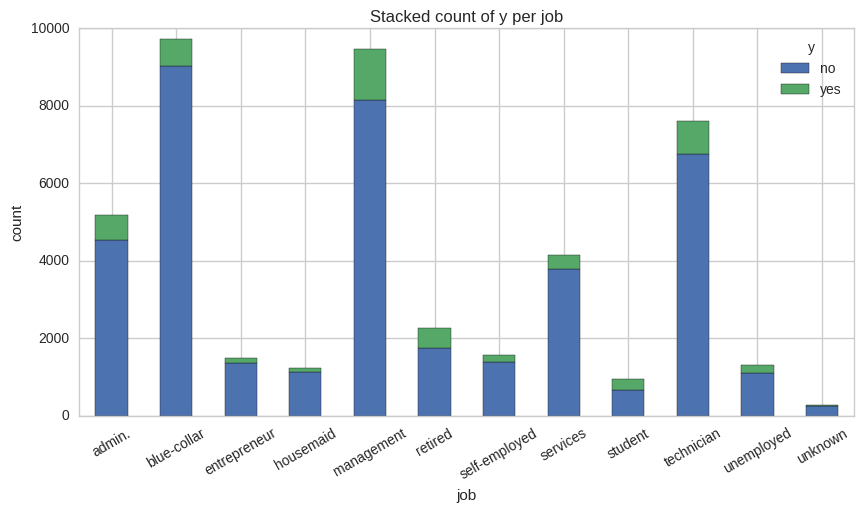

In [17]:
barplot("job", fig)

It seems that students are the most likely to subscribe to a bank term deposit, followed by retired and unemployed clients. This is interesting and we will try to go further on this later in this notebook.

In [18]:
df.groupby("loan").mean()

,age,balance,duration,campaign,pdays,previous,num_y
loan,,,,,,,
no,41.008823,1474.453631,259.559275,2.750336,41.192983,0.591435,0.126557
yes,40.555632,774.309912,250.845389,2.834622,34.982054,0.522087,0.066814


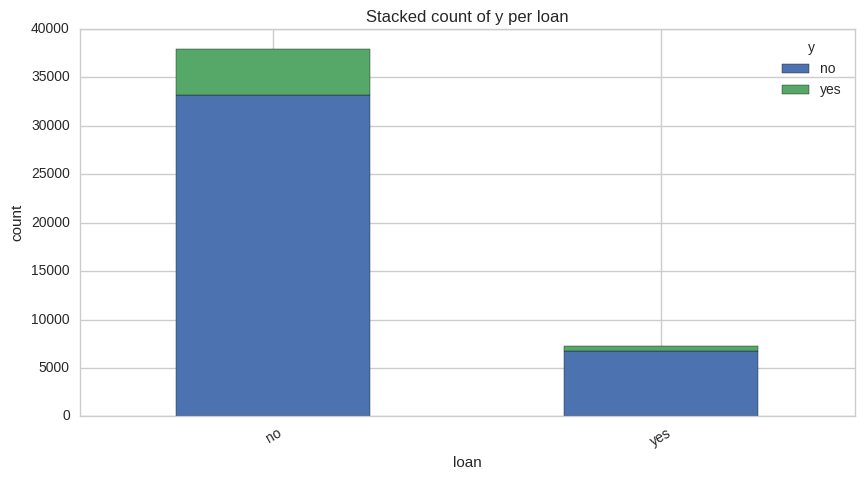

In [19]:
barplot("loan", fig)

Clients with personal loans are less likely to subscribe.

In [20]:
df.groupby("housing").mean()

,age,balance,duration,campaign,pdays,previous,num_y
housing,,,,,,,
no,43.139883,1596.501270,256.700911,2.845625,26.288581,0.484787,0.167024
yes,39.175288,1175.103064,259.331476,2.698488,51.312495,0.656665,0.077000


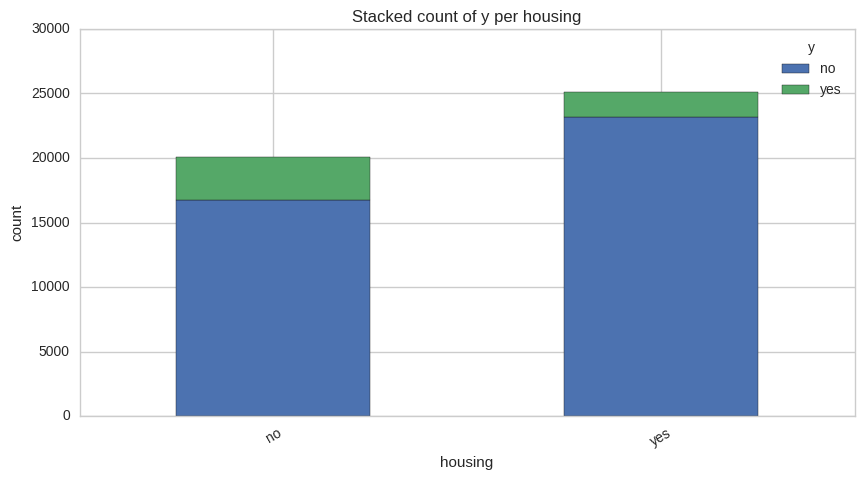

In [21]:
barplot("housing", fig)

Clients with housing loans are also less likely to subscribe.

In [22]:
df.groupby("marital").mean()

,age,balance,duration,campaign,pdays,previous,num_y
marital,,,,,,,
divorced,45.782984,1178.872287,262.517188,2.630882,41.001728,0.551373,0.119455
married,43.408099,1425.925590,253.412765,2.842875,37.950467,0.556552,0.101235
single,33.703440,1301.497654,266.497967,2.649805,44.652385,0.642690,0.149492


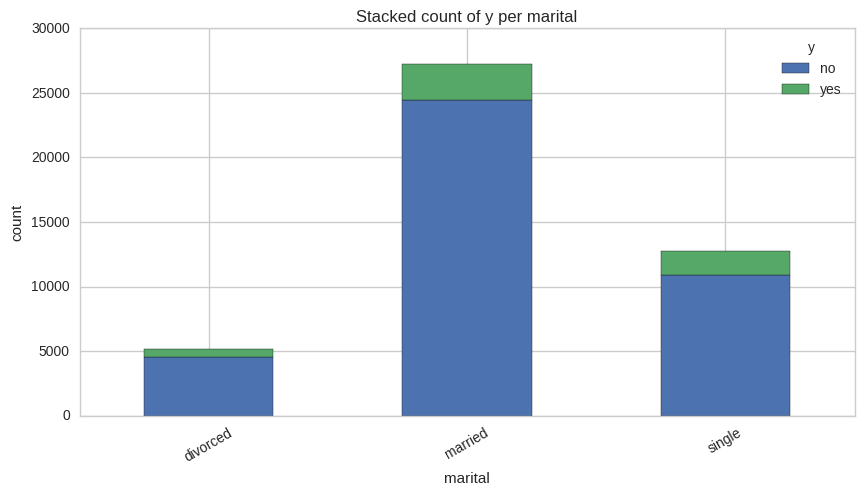

In [23]:
barplot("marital", fig)

Single clients are more likely to subscribe than divorced or married clients.

In [24]:
df.groupby("default").mean()

,age,balance,duration,campaign,pdays,previous,num_y
default,,,,,,,
no,40.961934,1389.806424,258.512749,2.756780,40.604536,0.586044,0.117961
yes,39.534969,-137.624540,239.115337,3.148466,18.042945,0.268712,0.063804


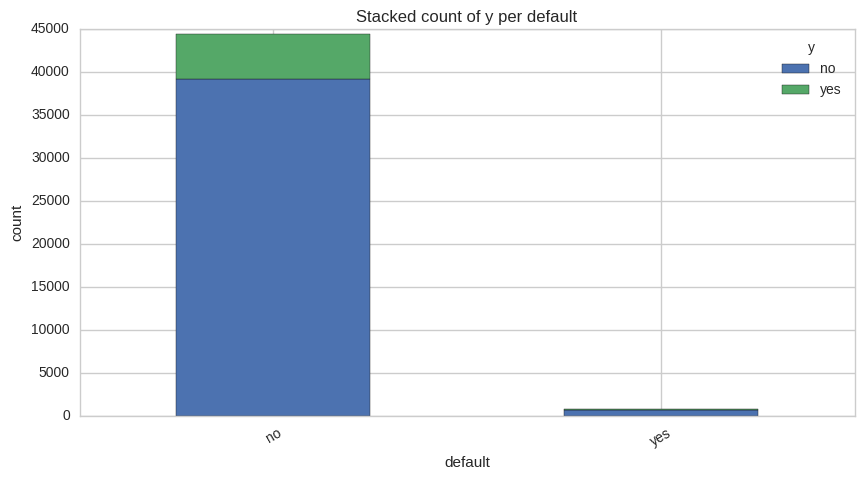

In [25]:
barplot("default", fig)

Clients who have credit default are less likely to subscribe.

In [26]:
df.groupby("contact").mean()

,age,balance,duration,campaign,pdays,previous,num_y
contact,,,,,,,
cellular,40.400785,1397.926993,263.013966,2.690114,56.885129,0.804064,0.149189
telephone,47.837922,1803.704061,235.366139,3.400895,46.312801,0.827254,0.134205
unknown,40.600077,1183.550384,252.340476,2.787481,1.299386,0.021966,0.040707


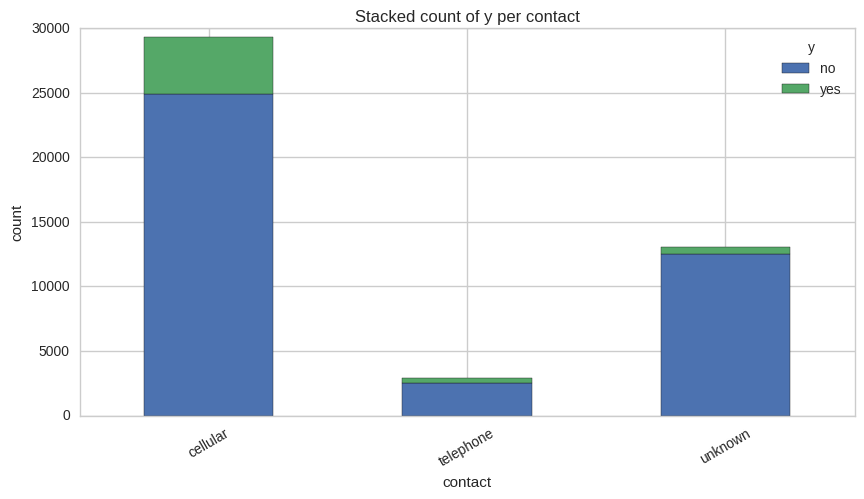

In [27]:
barplot("contact", fig)

Clients who are contacted on the cellular phones are more likely to subscribe.

In [28]:
df.groupby("weekday").mean()

,age,balance,duration,campaign,pdays,previous,num_y
weekday,,,,,,,
Friday,40.564112,1441.026517,240.558118,3.202870,7.715038,0.172539,0.064293
Monday,41.785197,1282.024595,256.819446,2.717044,34.015630,0.524997,0.120906
Saturday,41.531350,1352.225884,242.708199,2.243569,97.155949,1.730707,0.227492
Sunday,39.617726,1512.683930,250.116391,2.276829,98.116391,1.351575,0.213027
Thursday,41.298001,1413.047384,257.097976,3.120928,35.779368,0.430281,0.088228
Tuesday,40.719380,1296.255990,264.507523,2.564248,40.598128,0.594561,0.113451
Wednesday,40.698333,1350.472194,270.437395,2.692067,37.628511,0.523778,0.119615


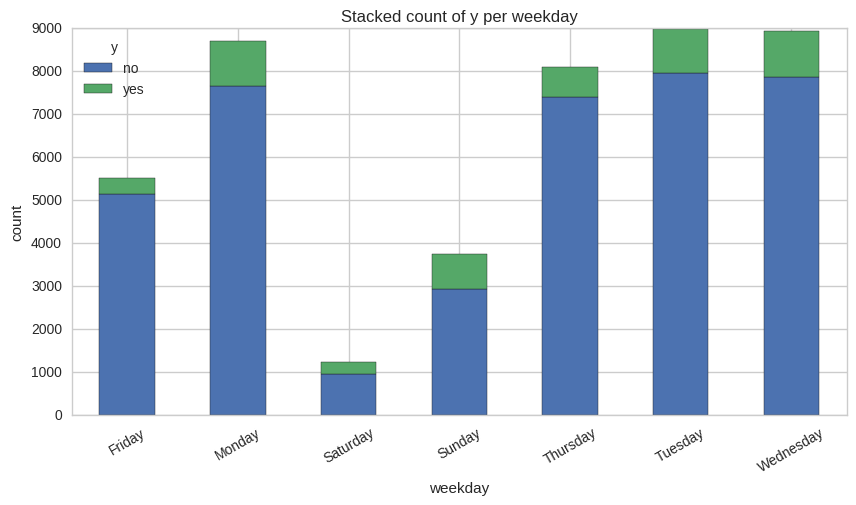

In [29]:
barplot("weekday", fig)

It seems that day of week is an important factor, as clients contacted on the weekends are more likely to subscribe to bank term loans.

In [30]:
df.groupby("month").mean()

,age,balance,duration,campaign,pdays,previous,num_y
month,,,,,,,
apr,39.770805,1542.551160,298.098909,1.955321,95.201910,1.052524,0.196794
aug,42.894509,1427.701777,232.402113,3.927325,13.328958,0.278374,0.110133
dec,44.457944,2315.672897,329.327103,2.196262,108.780374,1.803738,0.467290
feb,40.885240,1319.098905,248.298226,2.382031,68.702907,1.182710,0.166478
jan,40.493229,946.783321,268.220242,1.672131,67.898076,1.185317,0.101212
jul,41.008847,900.025526,267.975344,3.524438,8.032342,0.129949,0.090935
jun,42.438120,1608.222243,243.087811,3.135368,9.154465,0.197903,0.102228
mar,42.941300,2046.228512,244.400419,2.205451,71.228512,1.188679,0.519916
may,38.891109,1034.992590,260.922272,2.447552,52.157344,0.584992,0.067195


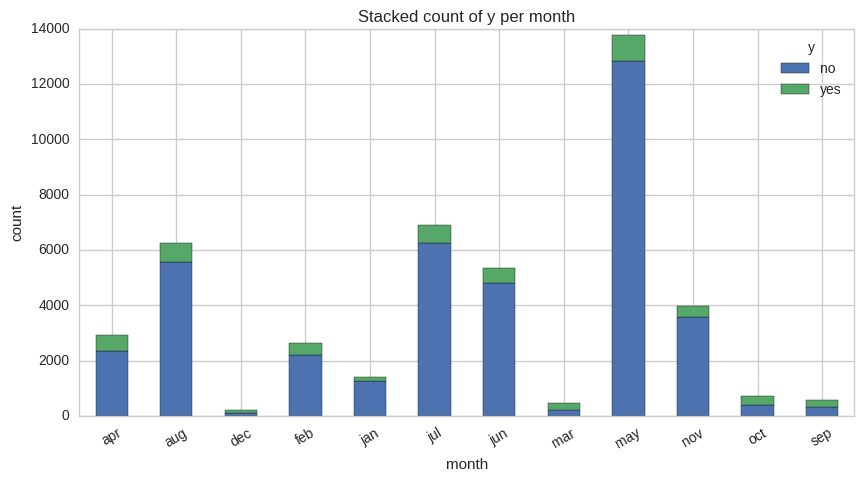

In [31]:
barplot("month", fig)

It seems that the month of last contact is also a good candidate for a good predictor, as contacts in December, March, October, and September are much more likely to result in a sale than contact in other months.

Based on these results, I would select `job`, `month`, `weekday`, `default`, `housing`, `loan` to be good candidates for predictors.

## Numeric variables
Now, let's do the same for the numeric independent variables.

In [32]:
"""
Function that produces and plots a histogram of the input variable `var`.
The parameter `bins` allows us to configure the number of bins to use.
`fig` is a constant and is just the matplotlib figure output.
`num_figs` and `pos` define whether to plot several images in
the same figure.
"""
def histogram(var, fig, bins=10, num_figs=1, pos=1):
    if not var or var == "" or not var in df.columns.tolist():
        return
    ax = fig.add_subplot(1, num_figs, pos)
    df[var].hist(bins=bins)
    plt.title('Histogram of {}'.format(var))
    plt.xlabel(var)
    plt.ylabel('Client count')

In [33]:
# [0;25) -> young
# [25;45) -> lower-adult
# [45;65) -> upper-adult
# [65;100) -> old
df["cat_age"] = pd.cut(df.age, [0, 25, 45, 65, 100], labels=["young","lower-adult","upper-adult","old"], right=False)

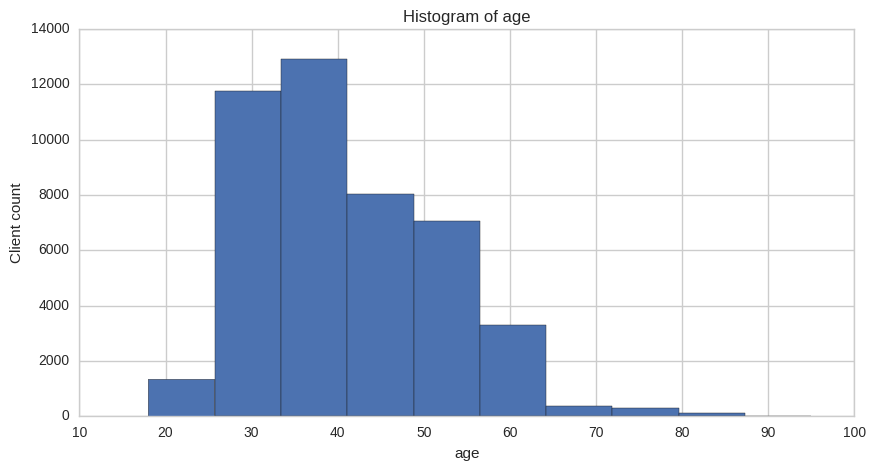

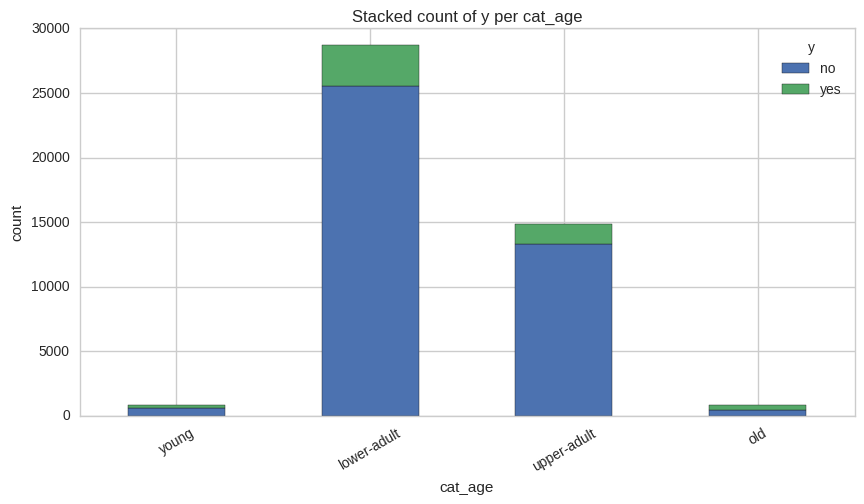

In [34]:
histogram("age", fig, 10, 2, 1)
barplot("cat_age", fig, "y", 2, 2)

As we've seen before, young people (correlates to students) and old people (correlates to retired) are the most likely to subscribe. We can think that maybe students are trying to invest some of their money thinking of the future, while older people are trying to leave behind some money for their family.

In [35]:
df["cat_balance"] = pd.cut(df.balance, [-10000,0,200,500,1000,1500,1000000], labels=["<0","<200","<500","<1000","<1500",">=1500"], right=False)

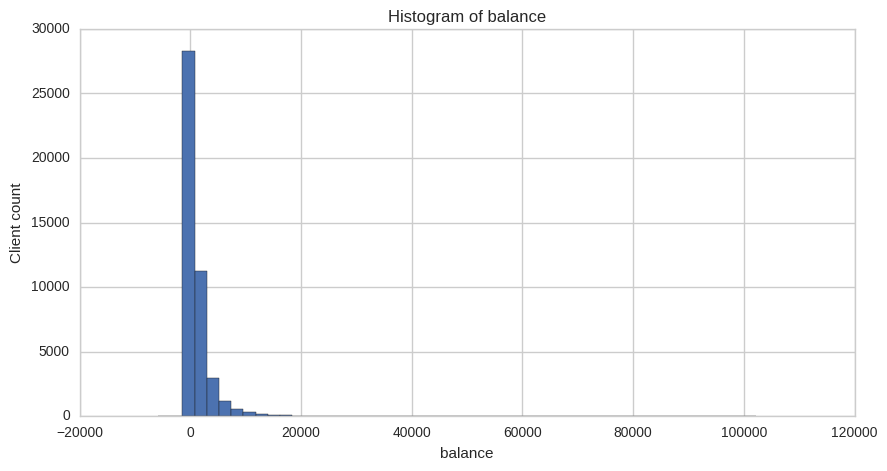

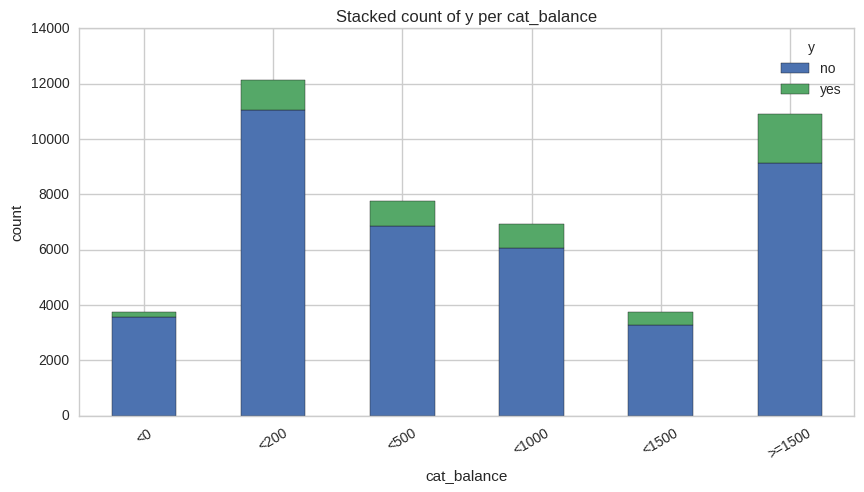

In [36]:
histogram("balance", fig, 50, 2, 1)
barplot("cat_balance", fig, "y", 2, 2)

Not very suprising, clients with a higher average balance are more likely to subscribe.

In [37]:
df["cat_duration"] = pd.cut(df.duration, [0, 100, 200, 300, 500, 5000], labels=["<100", "<200", "<300", "<500", ">=500"], right=False)

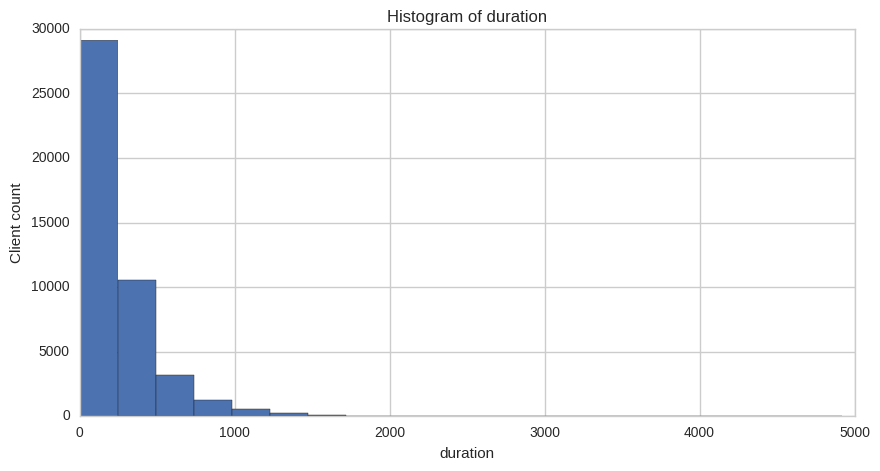

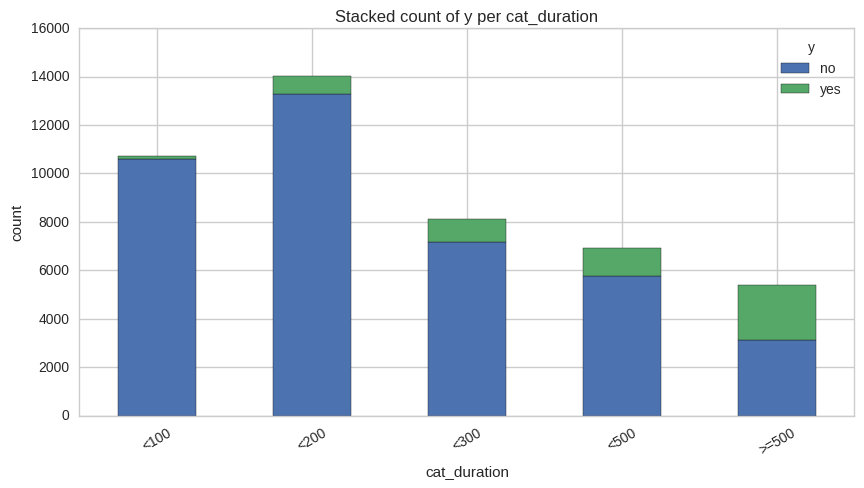

In [38]:
histogram("duration", fig, 20, 2, 1)
barplot("cat_duration", fig, "y", 2, 2)

As seen before, the duration is highly correlated with the success rate. This is due to fact that longer calls mean the agent spent more time with the client who wanted to subscribe. This doesn't mean that the agent called that client more times though.

In [39]:
df["cat_campaign"] = pd.cut(df.campaign, [1, 2, 3, 10, 65], labels=["One", "Two", "3-10", "10+"], right=False)

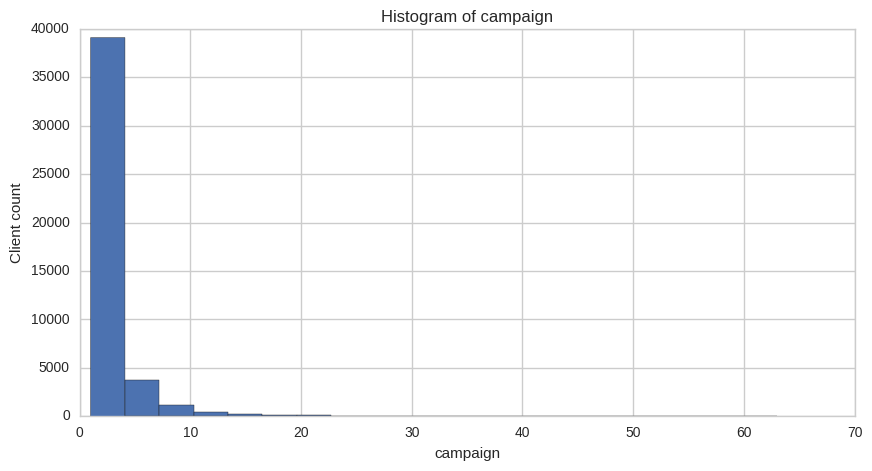

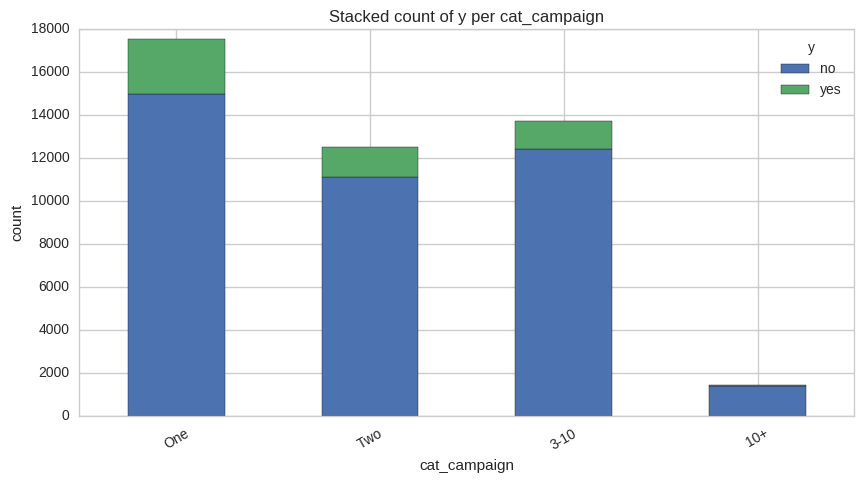

In [40]:
histogram("campaign", fig, 20, 2, 1)
barplot("cat_campaign", fig, "y", 2, 2)

This may be one of the most surprising early results: more calls do not correspond to more subscriptions. In fact, it the opposite: the best success rate is for only one campaign call.

In [41]:
df["cat_pdays"] = pd.cut(df.pdays, [-1,1,2,3,4,5,10,871], labels=["None", "1", "2", "3", "4", "5-10", "10+"], right=False)

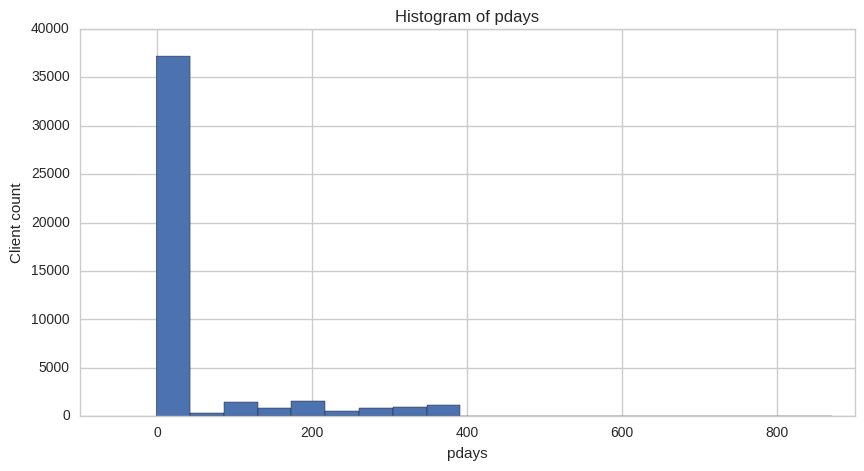

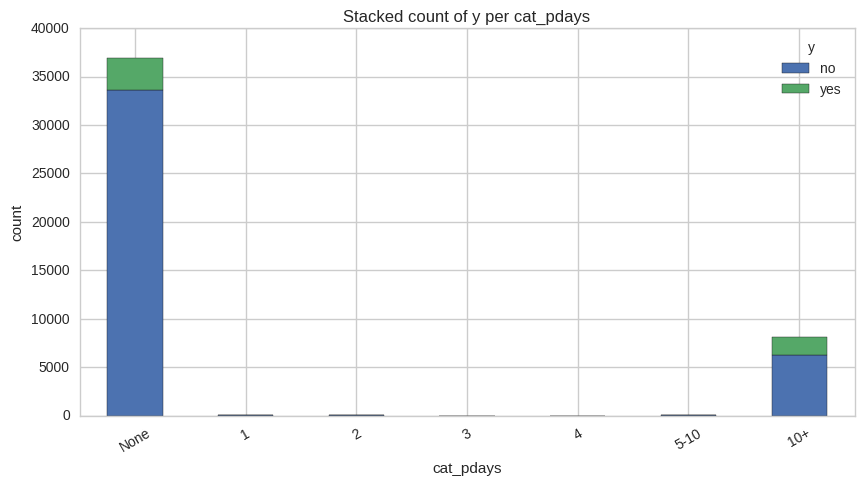

In [42]:
histogram("pdays", fig, 20, 2, 1)
barplot("cat_pdays", fig, "y", 2, 2)

Four days seems to be the ideal time to wait between successes. One day is also very good.

In [43]:
df["cat_previous"] = pd.cut(df.previous, [0, 1, 2, 3, 4, 5, 10, 1000], labels=["0", "1", "2", "3", "4", "5-10", "10+"], right=False)

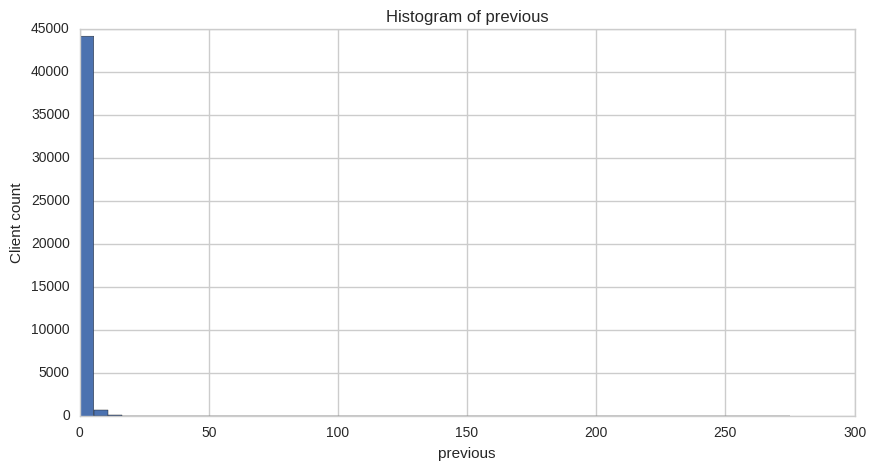

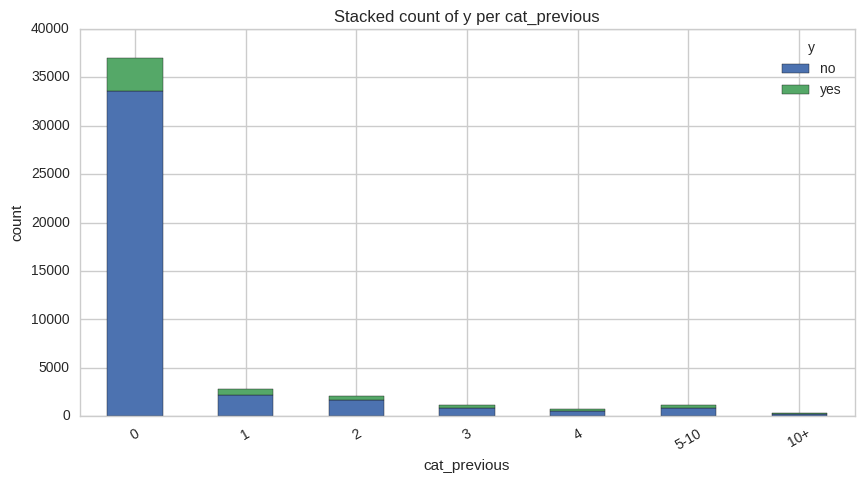

In [44]:
histogram("previous", fig, 50, 2, 1)
barplot("cat_previous", fig, "y", 2, 2)

It seems like anywhere between 1 to 5 previous contacts for a client have similar positive effects in success rate.

# Challenge questions and answers
Now that we've explored the dataset in detail, let's turn out heads to answering the questions asked.

## Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [45]:
pd.crosstab(df.job, df.loan).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

loan,no,yes
job,,
entrepreneur,0.760592,0.239408
services,0.798748,0.201252
admin.,0.808354,0.191646
blue-collar,0.826963,0.173037
technician,0.827695,0.172305
self-employed,0.854972,0.145028
retired,0.863516,0.136484
management,0.867520,0.132480
housemaid,0.877419,0.122581


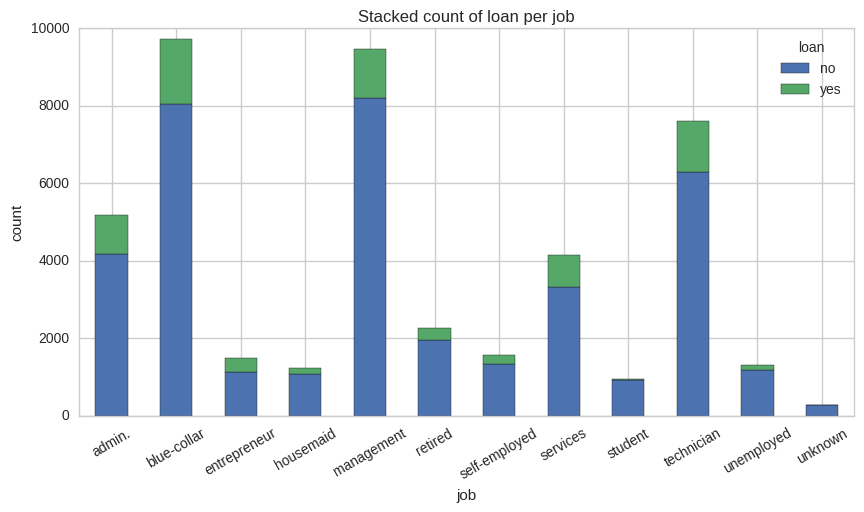

In [46]:
barplot("job", fig, "loan")

In [47]:
pd.crosstab(df.job, df.housing).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

housing,no,yes
job,,
blue-collar,0.275791,0.724209
services,0.334136,0.665864
admin.,0.384645,0.615355
entrepreneur,0.415602,0.584398
technician,0.458339,0.541661
management,0.505392,0.494608
self-employed,0.515516,0.484484
unemployed,0.583269,0.416731
housemaid,0.679032,0.320968


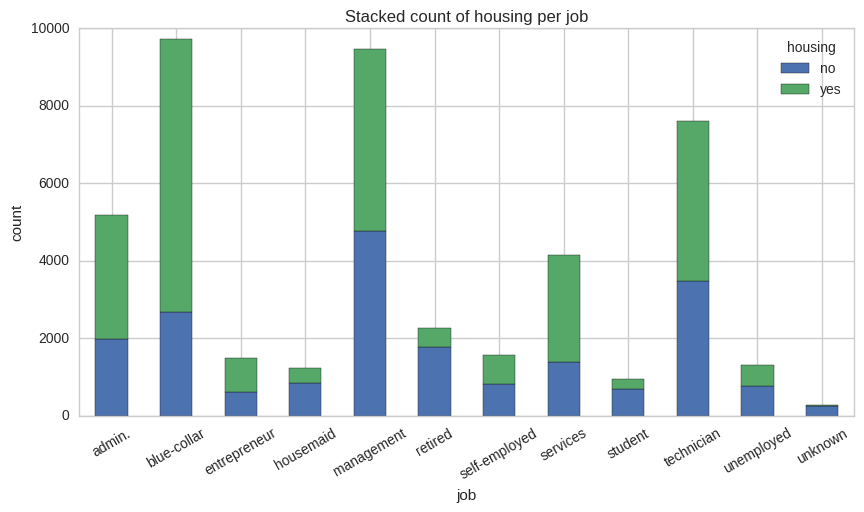

In [48]:
barplot("job", fig, "housing")

Answer:

Entrepreneurs are the most likely to have personal loans, with a 24% ratio or yes to no. However, the sample size for this job is considerably lower than for other jobs, such as blue-collar, management and technician. It is interesting to see that students tend not to have personal loans. We can guess that student loans are not considered personal loans here.

Considering housing loans, the number are a lot higher throughout job categories, being as high as 72% for blue-collar clients.

## Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

In [49]:
ct = pd.crosstab(df.campaign, df.y)
ct.rename(columns={"no": "tot_no", "yes": "tot_yes"}, inplace=True)
ct2 = pd.crosstab(df.campaign, df.y).apply(lambda r: r/r.sum(), axis=1)
ct2.rename(columns={"no": "prop_no", "yes": "prop_yes"}, inplace=True)
ct["prop_no"] = ct2["prop_no"]
ct["prop_yes"] = ct2["prop_yes"]
ct["cum_no"] = ct["tot_no"].cumsum()
ct["cum_yes"] = ct["tot_yes"].cumsum()
ct["cum_y_pct"] = ct["cum_yes"]/(ct["cum_no"]+ct["cum_yes"])
ct

y,tot_no,tot_yes,prop_no,prop_yes,cum_no,cum_yes,cum_y_pct
campaign,,,,,,,
1,14983,2561,0.854024,0.145976,14983,2561,0.145976
2,11104,1401,0.887965,0.112035,26087,3962,0.131851
3,4903,618,0.888064,0.111936,30990,4580,0.128760
4,3205,317,0.909994,0.090006,34195,4897,0.125269
5,1625,139,0.921202,0.078798,35820,5036,0.123262
6,1199,92,0.928737,0.071263,37019,5128,0.121669
7,688,47,0.936054,0.063946,37707,5175,0.120680
8,508,32,0.940741,0.059259,38215,5207,0.119916
9,306,21,0.935780,0.064220,38521,5228,0.119500


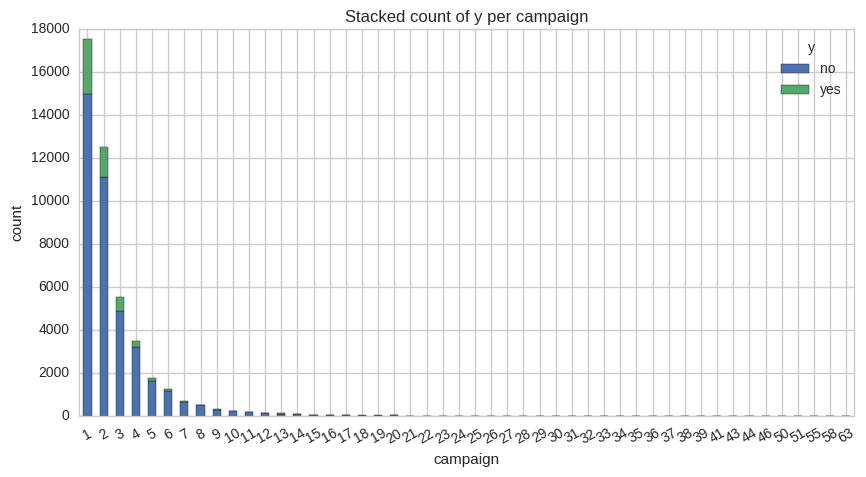

In [50]:
barplot("campaign", fig, prop=False)

Answer:

It can be seen that multiple calls do not yield higher return rates. Instead, the contrary seems to be true. It is most likely that the client makes a bank term deposit with a single call than multiple. Proportionally, there seems to be an exception to this rule when the number of calls is 32, but this result can be a result of a small sample size (9) for this particular number of calls.

Based on the cumulative sums and cumulative success rate, we can see that there is a plateau of success after around 5 or 6 calls, and it is always decreasing after the first call. This reinforces our idea that fewer calls are better.

## Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

Answer:

Based on the results above, it is safe to say that few calls are necessary in order to get a positive result. Indeed, if after a handful of calls no bank term deposit has been made, the outlook is not promising. As such, I would recommend the average number of calls to optimize results is 2, and the maximum number to be 6. This allows the tellers to spend less time with clients who will likely not make a deposit and have more time to reach out to new clients.

## O resultado da campanha anterior tem relevância na campanha atual?

In [51]:
pd.crosstab(df.poutcome, df.y).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

y,no,yes
poutcome,,
success,0.352747,0.647253
other,0.833152,0.166848
failure,0.873903,0.126097
unknown,0.908385,0.091615


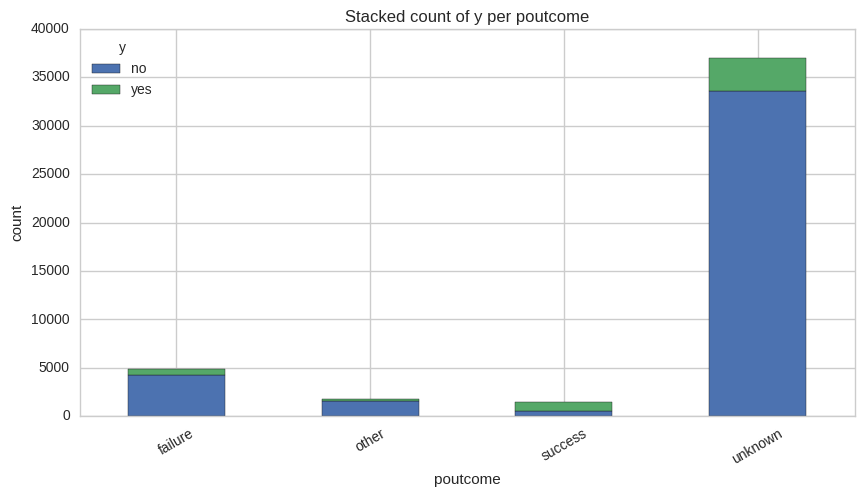

In [52]:
barplot("poutcome", fig)

Answer:

It seems that the outcome of the previous campaign has an impact on the current campaign. Indeed, 65% of clients who previously made a deposit do it again. However, this result is based on the smallest sample size out of the four categories, with "unknown" being the most prevalent previous outcome. It is interesting to note that almost 13% of clients who previously had not made a bank term deposit changed their minds for this new campaign.

## Qual o fator determinante para que o banco exija um seguro de crédito?

In [53]:
df.groupby("default").describe(include="int64").transpose()

default                    no           yes
age      count   44396.000000    815.000000
         mean       40.961934     39.534969
         std        10.638882      9.357804
         min        18.000000     21.000000
         25%        33.000000     32.000000
         50%        39.000000     38.000000
         75%        48.000000     47.000000
         max        95.000000     71.000000
balance  count   44396.000000    815.000000
         mean     1389.806424   -137.624540
         std      3063.275425    906.704678
         min     -4057.000000  -8019.000000
         25%        84.000000   -339.000000
         50%       468.000000     -7.000000
         75%      1462.250000     15.000000
         max    102127.000000  16486.000000
campaign count   44396.000000    815.000000
         mean        2.756780      3.148466
         std         3.087038      3.628145
         min         1.000000      1.000000
         25%         1.000000      1.000000
         50%         2.000000      2.000000
         75%         3.000000      4.000000
         max        63.000000     36.000000
duration count   44396.000000    815.000000
         mean      258.512749    239.115337
         std       258.239396    214.512375
         min         0.000000      3.000000
         25%       103.000000     97.000000
         50%       180.000000    172.000000
         75%       319.000000    305.000000
         max      4918.000000   1558.000000
num_y    count   44396.000000    815.000000
         mean        0.117961      0.063804
         std         0.322566      0.244553
         min         0.000000      0.000000
         25%         0.000000      0.000000
         50%         0.000000      0.000000
         75%         0.000000      0.000000
         max         1.000000      1.000000
pdays    count   44396.000000    815.000000
         mean       40.604536     18.042945
         std       100.504630     73.651493
         min        -1.000000     -1.000000
         25%        -1.000000     -1.000000
         50%        -1.000000     -1.000000
         75%        -1.000000     -1.000000
         max       871.000000    521.000000
previous count   44396.000000    815.000000
         mean        0.586044      0.268712
         std         2.313596      1.629787
         min         0.000000      0.000000
         25%         0.000000      0.000000
         50%         0.000000      0.000000
         75%         0.000000      0.000000
         max       275.000000     25.000000

In [54]:
df.groupby("default").describe(include="object").transpose()

default                    no          yes
contact   count         44396          815
          unique            3            3
          top        cellular     cellular
          freq          28786          499
education count         44396          815
          unique            4            4
          top       secondary    secondary
          freq          22744          458
housing   count         44396          815
          unique            2            2
          top             yes          yes
          freq          24695          435
job       count         44396          815
          unique           12           12
          top     blue-collar  blue-collar
          freq           9531          201
loan      count         44396          815
          unique            2            2
          top              no           no
          freq          37453          514
marital   count         44396          815
          unique            3            3
          top         married      married
          freq          26766          448
month     count         44396          815
          unique           12            9
          top             may          may
          freq          13526          240
poutcome  count         44396          815
          unique            4            4
          top         unknown      unknown
          freq          36201          758
weekday   count         44396          815
          unique            7            7
          top         Tuesday      Tuesday
          freq           8796          177
y         count         44396          815
          unique            2            2
          top              no           no
          freq          39159          763

In [55]:
df_balance_no_default = df.loc[df['default'] == "no"]["balance"]
df_balance_yes_default = df.loc[df['default'] == "yes"]["balance"]
stats.ttest_ind(df_balance_yes_default, df_balance_no_default)

Ttest_indResult(statistic=-14.223323582717237, pvalue=8.246277603417761e-46)

Answer:

We can see that account balance is significantly different between clients who have a credit default and those who don't. Indeed, on average, clients with no default have 1390 dollars in thei account, whereas clients who have a credit default have negative 138 dollars. As such, `balance` seems to be a significant factor for the bank to require a security deposit from the client. Using a two-sample t-test to compare them, we can affirm that there is  indeed a significant statistical difference, since the p-value is below the usual 5% threshold.

## Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

In [56]:
df.groupby("housing").describe(include="object").transpose()

housing                   no          yes
contact   count        20081        25130
          unique           3            3
          top       cellular     cellular
          freq         14682        14603
default   count        20081        25130
          unique           2            2
          top             no           no
          freq         19701        24695
education count        20081        25130
          unique           4            4
          top      secondary    secondary
          freq          9164        14038
job       count        20081        25130
          unique          12           12
          top     management  blue-collar
          freq          4780         7048
loan      count        20081        25130
          unique           2            2
          top             no           no
          freq         17204        20763
marital   count        20081        25130
          unique           3            3
          top        married      married
          freq         11893        15321
month     count        20081        25130
          unique          12           12
          top            aug          may
          freq          5144        12076
poutcome  count        20081        25130
          unique           4            4
          top        unknown      unknown
          freq         16969        19990
weekday   count        20081        25130
          unique           7            7
          top         Monday    Wednesday
          freq          4144         5092
y         count        20081        25130
          unique           2            2
          top             no           no
          freq         16727        23195

In [57]:
df.groupby("housing").describe(include="int64").transpose()

housing                    no           yes
age      count   20081.000000  25130.000000
         mean       43.139883     39.175288
         std        12.058696      8.926807
         min        18.000000     20.000000
         25%        33.000000     32.000000
         50%        42.000000     38.000000
         75%        52.000000     45.000000
         max        95.000000     78.000000
balance  count   20081.000000  25130.000000
         mean     1596.501270   1175.103064
         std      3613.405339   2483.285761
         min     -8019.000000  -4057.000000
         25%        85.000000     62.000000
         50%       507.000000    412.000000
         75%      1708.000000   1257.750000
         max    102127.000000  58544.000000
campaign count   20081.000000  25130.000000
         mean        2.845625      2.698488
         std         3.041508      3.140979
         min         1.000000      1.000000
         25%         1.000000      1.000000
         50%         2.000000      2.000000
         75%         3.000000      3.000000
         max        41.000000     63.000000
duration count   20081.000000  25130.000000
         mean      256.700911    259.331476
         std       256.529524    258.321907
         min         0.000000      0.000000
         25%       103.000000    103.000000
         50%       178.000000    182.000000
         75%       320.000000    318.000000
         max      3881.000000   4918.000000
num_y    count   20081.000000  25130.000000
         mean        0.167024      0.077000
         std         0.373006      0.266596
         min         0.000000      0.000000
         25%         0.000000      0.000000
         50%         0.000000      0.000000
         75%         0.000000      0.000000
         max         1.000000      1.000000
pdays    count   20081.000000  25130.000000
         mean       26.288581     51.312495
         std        77.461032    113.862848
         min        -1.000000     -1.000000
         25%        -1.000000     -1.000000
         50%        -1.000000     -1.000000
         75%        -1.000000     -1.000000
         max       871.000000    854.000000
previous count   20081.000000  25130.000000
         mean        0.484787      0.656665
         std         1.660227      2.707428
         min         0.000000      0.000000
         25%         0.000000      0.000000
         50%         0.000000      0.000000
         75%         0.000000      0.000000
         max        37.000000    275.000000

Answer:

The most prominent features of a client who has a housing loan are:
* no default
* secondary education
* blue-collar job
* no private loan
* married
* 39 years old
* average account balance of 1175 dollars

# Machine Learning
Here, I will apply two machine learning models to predict the outcome based on the factors. For categorical variables, I will convert them into dummy variables (remembering to drop the first category to avoid multicollinearity). I will implement a logistic regression model as well as a random forest classifier.

Given more time, I would have also performed cross-validation instead of only splitting the dataset once into train and test, so the final results would be robust. Additionally, more feature exploration and engineering could give us better predictors than the raw ones used.

## Import libraries, adjust the dataset

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [59]:
# Dummy variables
df.drop(['num_y','date','cat_age','cat_balance','cat_duration','cat_campaign','cat_pdays','cat_previous'], axis=1, inplace=True)
categorical = ['job','marital','education','default','housing','loan','contact','weekday','month','poutcome']
for c in categorical:
    cat_list = pd.get_dummies(df[c], prefix=c, drop_first=True)
    tmp = df.join(cat_list)
    df = tmp
to_keep = [i for i in df.columns.values.tolist() if i not in categorical]
df_dummy = df[to_keep]
df_dummy.columns

Index([u'age', u'balance', u'duration', u'campaign', u'pdays', u'previous',
       u'y', u'job_blue-collar', u'job_entrepreneur', u'job_housemaid',
       u'job_management', u'job_retired', u'job_self-employed',
       u'job_services', u'job_student', u'job_technician', u'job_unemployed',
       u'job_unknown', u'marital_married', u'marital_single',
       u'education_secondary', u'education_tertiary', u'education_unknown',
       u'default_yes', u'housing_yes', u'loan_yes', u'contact_telephone',
       u'contact_unknown', u'weekday_Monday', u'weekday_Saturday',
       u'weekday_Sunday', u'weekday_Thursday', u'weekday_Tuesday',
       u'weekday_Wednesday', u'month_aug', u'month_dec', u'month_feb',
       u'month_jan', u'month_jul', u'month_jun', u'month_mar', u'month_may',
       u'month_nov', u'month_oct', u'month_sep', u'poutcome_other',
       u'poutcome_success', u'poutcome_unknown'],
      dtype='object')

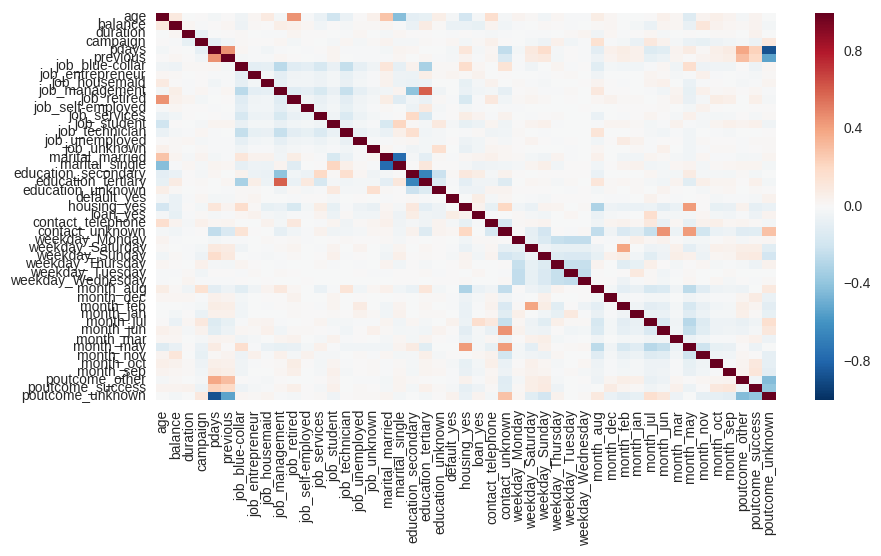

In [60]:
sns.heatmap(df_dummy.corr())

There are no red flags about multicollinearity. The correlation plot looks ok. If we hadn't dropped the first dummy variable for each case, then we would have seen big areas with very high correlation.

In [61]:
# Separate X and y datasets.
X = df_dummy.drop("y", axis=1)
y = df_dummy.y

## Logistic regression

In [62]:
# Split X and y into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print X_train.shape, X_test.shape

(36168, 47) (9043, 47)


In [63]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
y_pred = classifier.predict(X_test)
print confusion_matrix(y_test, y_pred)

[[7751  229]
 [ 696  367]]


The logistic regression model correctly predicted 7751+367 results, and incorrectly classified 229+696 clients. We can see that the model is not just predicting a single class. Let's take a look at the accuracy to see whether it is better than just guessing "no" for every client.

In [65]:
print 'Accuracy of logistic regression classifier on test set: {:.3f}'.format(classifier.score(X_test, y_test))

Accuracy of logistic regression classifier on test set: 0.898


In [66]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

         no       0.92      0.97      0.94      7980
        yes       0.62      0.35      0.44      1063

avg / total       0.88      0.90      0.88      9043



With an accuracy of 90% in the test set, we can say that this model performed slightly better than the baseline (88.3%). Additionally, the precision $\frac{tp}{tp+fp}$ of the model is 88% (the model is good at correctly classifying a "no"), and the recall $\frac{tp}{tp+fn}$  is 90% (the model is good at correctly classifying a "yes"). The F1 score is 88% overall.

However, we can see that the model performs significantly better for "no" clients than "yes" clients. It is something that we can try to improve upon.

In [67]:
import statsmodels.api as sm
logit = sm.Logit(np.asarray([1 if i=="yes" else 0 for i in y]), np.asarray(X))
result = logit.fit()
result.summary2()

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.240051
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            No. Iterations:   8.0000    
Dependent Variable: y                Pseudo R-squared: 0.335     
Date:               2018-04-05 09:09 AIC:              21799.9105
No. Observations:   45211            BIC:              22209.7080
Df Model:           46               Log-Likelihood:   -10853.   
Df Residuals:       45164            LL-Null:          -16315.   
Converged:          1.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.0161     0.0018    -8.7359   0.0000   -0.0197   -0.0125
x2        0.0000     0.0000     2.4524   0.0142    0.0000    0.0000
x3        0.0042     0.0001    64.4040   0.0000    0.0040    0.0043
x4       -0.0963     0.0103    -9.3901   0.0000   -0.1163   -0.0762
x5       -0.0017     0.0003    -5.9363   0.0000   -0.0023   -0.0011
x6        0.0008     0.0074     0.1044   0.9169   -0.0137    0.0152
x7       -0.5553     0.0689    -8.0581   0.0000   -0.6904   -0.4202
x8       -0.5135     0.1239    -4.1436   0.0000   -0.7563   -0.2706
x9       -0.7338     0.1341    -5.4713   0.0000   -0.9967   -0.4709
x10      -0.3166     0.0708    -4.4726   0.0000   -0.4554   -0.1779
x11       0.2777     0.0962     2.8860   0.0039    0.0891    0.4663
x12      -0.4634     0.1102    -4.2048   0.0000   -0.6794   -0.2474
x13      -0.4035     0.0815    -4.9476   0.0000   -0.5633   -0.2436
x14       0.0366     0.1052     0.3476   0.7281   -0.1696    0.2428
x15      -0.3422     0.0661    -5.1767   0.0000   -0.4718   -0.2126
x16      -0.3665     0.1096    -3.3447   0.0008   -0.5813   -0.1517
x17      -0.4652     0.2318    -2.0072   0.0447   -0.9195   -0.0109
x18      -0.4077     0.0542    -7.5229   0.0000   -0.5139   -0.3015
x19      -0.2703     0.0598    -4.5217   0.0000   -0.3874   -0.1531
x20      -0.1302     0.0582    -2.2353   0.0254   -0.2443   -0.0160
x21       0.0512     0.0694     0.7374   0.4609   -0.0848    0.1871
x22       0.0140     0.1012     0.1387   0.8897   -0.1843    0.2123
x23      -0.0193     0.1626    -0.1187   0.9055   -0.3381    0.2995
x24      -0.7882     0.0429   -18.3892   0.0000   -0.8722   -0.7041
x25      -0.4677     0.0598    -7.8207   0.0000   -0.5849   -0.3505
x26      -0.1103     0.0748    -1.4753   0.1401   -0.2569    0.0362
x27      -1.5382     0.0747   -20.5831   0.0000   -1.6846   -1.3917
x28      -0.1794     0.0716    -2.5044   0.0123   -0.3198   -0.0390
x29      -0.0889     0.1103    -0.8056   0.4205   -0.3052    0.1274
x30      -0.0089     0.0804    -0.1103   0.9121   -0.1665    0.1488
x31      -0.4126     0.0743    -5.5539   0.0000   -0.5583   -0.2670
x32      -0.2611     0.0714    -3.6541   0.0003   -0.4011   -0.1210
x33      -0.2485     0.0704    -3.5295   0.0004   -0.3864   -0.1105
x34      -0.9037     0.0757   -11.9440   0.0000   -1.0520   -0.7554
x35       0.4168     0.1741     2.3939   0.0167    0.0756    0.7581
x36      -0.5567     0.0847    -6.5767   0.0000   -0.7226   -0.3908
x37      -1.4310     0.1187   -12.0540   0.0000   -1.6637   -1.1983
x38      -1.0138     0.0752   -13.4905   0.0000   -1.1611   -0.8665
x39       0.1011     0.0873     1.1571   0.2472   -0.0701    0.2722
x40       1.2903     0.1176    10.9679   0.0000    1.0597    1.5209
x41      -0.6475     0.0684    -9.4601   0.0000   -0.7816   -0.5133
x42      -1.1153     0.0815   -13.6845   0.0000   -1.2751   -0.9556
x43       0.6550     0.1058     6.1905   0.0000    0.4477    0.8624
x44       0.5891     0.1171     5.0322   0.0000    0.3596    0.8185
x45       0.0172     0.0881     0.1949   0.8455   -0.1555    0.1898
x46       2.0336     0.0792    25.6808   0.0000    1.8784    2.1888
x47      -0.6437     0.0809    -7.9611   0.0000   -

In [68]:
# Remove non-significant factors (p-value>0.05)
X.drop(X.columns[[5,13,20,21,22,25,28,38,44]], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print X_train.shape, X_test.shape
logit = sm.Logit(np.asarray([1 if i=="yes" else 0 for i in y]), np.asarray(X))
result = logit.fit()
result.summary2()

(36168, 38) (9043, 38)
Optimization terminated successfully.
         Current function value: 0.240108
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            No. Iterations:   8.0000    
Dependent Variable: y                Pseudo R-squared: 0.335     
Date:               2018-04-05 09:09 AIC:              21787.0321
No. Observations:   45211            BIC:              22118.3577
Df Model:           37               Log-Likelihood:   -10856.   
Df Residuals:       45173            LL-Null:          -16315.   
Converged:          1.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.0163     0.0017    -9.3607   0.0000   -0.0197   -0.0129
x2        0.0000     0.0000     2.5014   0.0124    0.0000    0.0000
x3        0.0042     0.0001    64.5338   0.0000    0.0040    0.0043
x4       -0.0962     0.0102    -9.4638   0.0000   -0.1162   -0.0763
x5       -0.0017     0.0003    -5.9385   0.0000   -0.0022   -0.0011
x6       -0.5679     0.0652    -8.7163   0.0000   -0.6956   -0.4402
x7       -0.5058     0.1217    -4.1563   0.0000   -0.7444   -0.2673
x8       -0.7423     0.1320    -5.6251   0.0000   -1.0009   -0.4837
x9       -0.2950     0.0617    -4.7822   0.0000   -0.4159   -0.1741
x10       0.2602     0.0940     2.7691   0.0056    0.0760    0.4444
x11      -0.4504     0.1065    -4.2297   0.0000   -0.6591   -0.2417
x12      -0.4041     0.0791    -5.1066   0.0000   -0.5592   -0.2490
x13      -0.3355     0.0619    -5.4199   0.0000   -0.4569   -0.2142
x14      -0.3675     0.1072    -3.4279   0.0006   -0.5777   -0.1574
x15      -0.4815     0.2286    -2.1065   0.0352   -0.9296   -0.0335
x16      -0.4015     0.0534    -7.5187   0.0000   -0.5062   -0.2968
x17      -0.2549     0.0559    -4.5614   0.0000   -0.3644   -0.1454
x18      -0.1562     0.0408    -3.8300   0.0001   -0.2361   -0.0763
x19      -0.7915     0.0422   -18.7457   0.0000   -0.8742   -0.7087
x20      -0.4656     0.0596    -7.8146   0.0000   -0.5824   -0.3488
x21      -1.4825     0.0655   -22.6194   0.0000   -1.6109   -1.3540
x22      -0.1360     0.0625    -2.1751   0.0296   -0.2586   -0.0135
x23       0.0375     0.0707     0.5301   0.5961   -0.1011    0.1760
x24      -0.3751     0.0674    -5.5690   0.0000   -0.5071   -0.2431
x25      -0.2210     0.0628    -3.5215   0.0004   -0.3440   -0.0980
x26      -0.2114     0.0623    -3.3954   0.0007   -0.3334   -0.0894
x27      -0.9245     0.0673   -13.7391   0.0000   -1.0564   -0.7926
x28       0.3813     0.1704     2.2377   0.0252    0.0473    0.7152
x29      -0.6005     0.0755    -7.9584   0.0000   -0.7484   -0.4526
x30      -1.4614     0.1141   -12.8099   0.0000   -1.6850   -1.2378
x31      -1.0447     0.0683   -15.2921   0.0000   -1.1786   -0.9108
x32       1.2561     0.1124    11.1755   0.0000    1.0358    1.4764
x33      -0.6885     0.0573   -12.0167   0.0000   -0.8008   -0.5762
x34      -1.1373     0.0754   -15.0897   0.0000   -1.2850   -0.9895
x35       0.6135     0.0998     6.1468   0.0000    0.4179    0.8092
x36       0.5512     0.1114     4.9478   0.0000    0.3329    0.7696
x37       2.0412     0.0745    27.3912   0.0000    1.8952    2.1873
x38      -0.6352     0.0730    -8.7052   0.0000   -0.7783   -0.4922
=================================================================

"""

In [69]:
# Remove non-significant factors (p-value>0.05)
X.drop(X.columns[[22]], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print X_train.shape, X_test.shape
logit = sm.Logit(np.asarray([1 if i=="yes" else 0 for i in y]), np.asarray(X))
result = logit.fit()
result.summary2()

(36168, 37) (9043, 37)
Optimization terminated successfully.
         Current function value: 0.240111
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            No. Iterations:   8.0000    
Dependent Variable: y                Pseudo R-squared: 0.335     
Date:               2018-04-05 09:09 AIC:              21785.3130
No. Observations:   45211            BIC:              22107.9195
Df Model:           36               Log-Likelihood:   -10856.   
Df Residuals:       45174            LL-Null:          -16315.   
Converged:          1.0000           Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.0161     0.0017    -9.4759   0.0000   -0.0194   -0.0127
x2        0.0000     0.0000     2.5065   0.0122    0.0000    0.0000
x3        0.0042     0.0001    64.5394   0.0000    0.0040    0.0043
x4       -0.0961     0.0102    -9.4566   0.0000   -0.1160   -0.0762
x5       -0.0016     0.0003    -5.9216   0.0000   -0.0022   -0.0011
x6       -0.5662     0.0651    -8.6995   0.0000   -0.6937   -0.4386
x7       -0.5040     0.1217    -4.1427   0.0000   -0.7424   -0.2655
x8       -0.7411     0.1319    -5.6170   0.0000   -0.9997   -0.4825
x9       -0.2932     0.0616    -4.7597   0.0000   -0.4140   -0.1725
x10       0.2589     0.0940     2.7557   0.0059    0.0748    0.4431
x11      -0.4486     0.1064    -4.2155   0.0000   -0.6572   -0.2400
x12      -0.4027     0.0791    -5.0916   0.0000   -0.5578   -0.2477
x13      -0.3343     0.0619    -5.4026   0.0000   -0.4555   -0.2130
x14      -0.3661     0.1072    -3.4150   0.0006   -0.5762   -0.1560
x15      -0.4797     0.2285    -2.0992   0.0358   -0.9276   -0.0318
x16      -0.3980     0.0530    -7.5081   0.0000   -0.5018   -0.2941
x17      -0.2487     0.0547    -4.5489   0.0000   -0.3559   -0.1416
x18      -0.1550     0.0407    -3.8063   0.0001   -0.2348   -0.0752
x19      -0.7900     0.0421   -18.7488   0.0000   -0.8726   -0.7074
x20      -0.4654     0.0596    -7.8115   0.0000   -0.5822   -0.3486
x21      -1.4905     0.0637   -23.3821   0.0000   -1.6155   -1.3656
x22      -0.1531     0.0535    -2.8584   0.0043   -0.2580   -0.0481
x23      -0.3923     0.0590    -6.6469   0.0000   -0.5079   -0.2766
x24      -0.2380     0.0539    -4.4132   0.0000   -0.3436   -0.1323
x25      -0.2286     0.0531    -4.3082   0.0000   -0.3326   -0.1246
x26      -0.9295     0.0666   -13.9491   0.0000   -1.0601   -0.7989
x27       0.3838     0.1703     2.2534   0.0242    0.0500    0.7176
x28      -0.6051     0.0750    -8.0704   0.0000   -0.7521   -0.4582
x29      -1.4649     0.1139   -12.8611   0.0000   -1.6882   -1.2417
x30      -1.0500     0.0676   -15.5312   0.0000   -1.1825   -0.9175
x31       1.2568     0.1124    11.1832   0.0000    1.0365    1.4771
x32      -0.6871     0.0572   -12.0020   0.0000   -0.7993   -0.5749
x33      -1.1425     0.0747   -15.2906   0.0000   -1.2889   -0.9961
x34       0.6118     0.0998     6.1324   0.0000    0.4163    0.8074
x35       0.5497     0.1114     4.9357   0.0000    0.3314    0.7679
x36       2.0450     0.0742    27.5627   0.0000    1.8996    2.1904
x37      -0.6294     0.0722    -8.7224   0.0000   -0.7708   -0.4880
=================================================================

"""

All predictors are significant within our threshold of 5%. Let's build the logistic regression model again to see if things improved.

In [70]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [71]:
print confusion_matrix(y_test, y_pred)
print 'Accuracy of logistic regression classifier on test set: {:.3f}'.format(classifier.score(X_test, y_test))
print classification_report(y_test, y_pred)

[[7753  227]
 [ 688  375]]
Accuracy of logistic regression classifier on test set: 0.899
             precision    recall  f1-score   support

         no       0.92      0.97      0.94      7980
        yes       0.62      0.35      0.45      1063

avg / total       0.88      0.90      0.89      9043



Removing some extra factors improved the model very slightly.

## Random forest classifier

In [72]:
rf = RandomForestClassifier(n_estimators=100)
grid = GridSearchCV(rf, param_grid={}, scoring='accuracy', iid=False, cv=5)
grid.fit(X, y=="yes")
print "Best accuracy: {:3f}".format(grid.best_score_)

Best accuracy: 0.692361


The random forest classifier did not perform very well in this case. It is possible that with more time I would have been better able to fine-tune the hyper-parameters of the model in order to improve the results. The simple logistic regression we built earlier performs much better (and faster) than this random forest classifier. Indeed, just guessing "no" for every client would yield a better accuracy than this model.